# BiLSTM for Protein Secondary Structure Prediction

This notebook implements a Bidirectional LSTM model to predict protein secondary structure (3-state: Coil, Helix, Sheet) from amino acid sequences.

## Table of Contents
1. [Imports and Setup](#1-imports-and-setup)
2. [Load and Explore Data](#2-load-and-explore-data)
3. [Create Amino Acid Vocabulary](#3-create-amino-acid-vocabulary)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Build BiLSTM Model](#5-build-bilstm-model)
6. [Train the Model](#6-train-the-model)
7. [Evaluate Performance](#7-evaluate-performance)
8. [Predictions and Visualization](#8-predictions-and-visualization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## 1. Imports and Setup

Import all necessary libraries for data processing, model building, and evaluation.

In [ ]:
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Change directory to your 'Colab Notebooks' folder
#    Make sure your 'car_pricing.csv' file is in this folder
%cd /content/drive/MyDrive/CIS_508/team_project

# 3. Verify the current directory
print(f"Current working directory: {os.getcwd()}")

Mounted at /content/drive
/content/drive/MyDrive/CIS_508/team_project
Current working directory: /content/drive/MyDrive/CIS_508/team_project


In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
!pip install tensorflow
!pip install keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional,
    Dense, TimeDistributed, Dropout, Masking
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Sklearn for splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


---
## 2. Load and Explore Data

Load the protein sequence dataset and understand its structure.

In [ ]:
# Load the dataset
df = pd.read_csv('training_data_2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (15079, 12)

Columns: ['pdb_id', 'chain_code', 'seq', 'sst8', 'sst3', 'len_x', 'has_nonstd_aa', 'len_y', 'method', 'resol', 'rfac', 'freerfac']


,pdb_id,chain_code,seq,sst8,sst3,len_x,has_nonstd_aa,len_y,method,resol,rfac,freerfac
0,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,CCCTTBCCTTCHHHHHHTCBSSGGGSCHHHHCCTTSCGGGCCGGGB...,CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHE...,83,False,83,XRAY,0.48,0.072,0.078
1,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,CEECSSHHHHHHHHHHHTTTCCHHHHHHHHSCEECSSSCCCTTSCC,CEECCCHHHHHHHHHHHCCCCCHHHHHHHHCCEECCCCCCCCCCCC,46,False,46,XRAY,0.48,0.127,NaN
2,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,CCEEEETTTCCEEETTTCBGGGTBCTTCCGGGSCTTCBCTTTCCBG...,CCEEEECCCCCEEECCCCEHHHCECCCCCHHHCCCCCECCCCCCEH...,54,False,54,XRAY,0.59,0.135,0.146
3,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,CCCEEEESSCBCTTCBCCGGGEEEECCSSCCSBGGGHHHHTTCBBS...,CCCEEEECCCECCCCECCHHHEEEECCCCCCCEHHHHHHHCCCEEC...,64,False,64,XRAY,0.62,0.139,0.155
4,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,CGGGCCCCSEEEEEEEEESCCSSCTTSCCBSSCEEEEEHHHHTSCT...,CHHHCCCCCEEEEEEEEECCCCCCCCCCCECCCEEEEEHHHHCCCC...,180,False,180,XRAY,0.64,0.122,0.129


In [ ]:
# Examine sequence and target columns
print("Sample sequence (seq):")
print(df['seq'].iloc[0])
print(f"\nLength: {len(df['seq'].iloc[0])}")

print("\n" + "="*50)
print("\nCorresponding secondary structure (sst3):")
print(df['sst3'].iloc[0])
print(f"\nLength: {len(df['sst3'].iloc[0])}")

Sample sequence (seq):
AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANCQFMQANVGEGDWKGCQLFPGKLINVNGWCASWTLKAG

Length: 83


Corresponding secondary structure (sst3):
CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHECCEEEEEEECCEEEECCCCCCEEECCCECCCCCECCC

Length: 83


In [ ]:
# Verify sequence and label lengths match
df['seq_len'] = df['seq'].apply(len)
df['sst3_len'] = df['sst3'].apply(len)
df['len_match'] = df['seq_len'] == df['sst3_len']

print(f"All lengths match: {df['len_match'].all()}")
print(f"\nSequence length statistics:")
print(df['seq_len'].describe())

All lengths match: True

Sequence length statistics:
count    15079.000000
mean       249.660123
std        156.630394
min          1.000000
25%        135.000000
50%        216.000000
75%        327.000000
max       2128.000000
Name: seq_len, dtype: float64


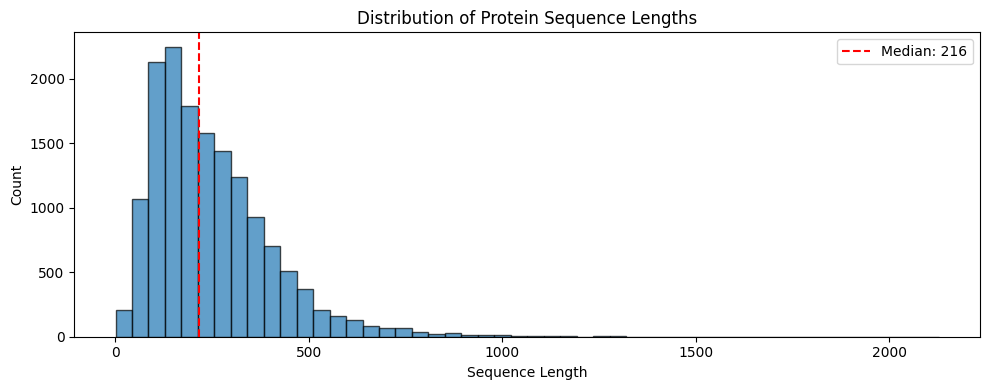

In [ ]:
# Visualize sequence length distribution
plt.figure(figsize=(10, 4))
plt.hist(df['seq_len'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Protein Sequence Lengths')
plt.axvline(df['seq_len'].median(), color='red', linestyle='--', label=f'Median: {df["seq_len"].median():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Analyze unique amino acids in the dataset
all_amino_acids = set(''.join(df['seq'].values))
print(f"Unique amino acids found: {sorted(all_amino_acids)}")
print(f"Count: {len(all_amino_acids)}")

# Analyze target classes
all_structures = set(''.join(df['sst3'].values))
print(f"\nUnique secondary structure labels: {sorted(all_structures)}")
print(f"Count: {len(all_structures)}")

Unique amino acids found: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
Count: 21

Unique secondary structure labels: ['C', 'E', 'H']
Count: 3


In [ ]:
# Count distribution of secondary structure classes
all_sst3 = ''.join(df['sst3'].values)
sst3_counts = pd.Series(list(all_sst3)).value_counts()

In [ ]:
print(sst3_counts)

C    1452095
H    1443444
E     869086
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Secondary Structure Classes\n(C=Coil, H=Helix, E=Sheet)')

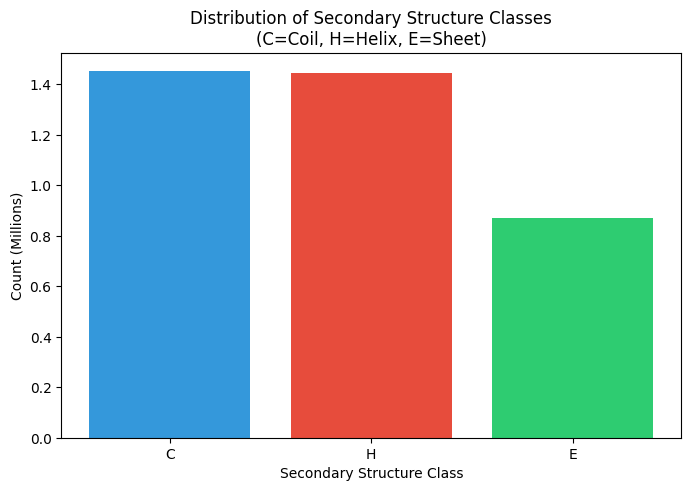

In [ ]:
plt.figure(figsize=(8, 5))
colors = {'C': '#3498db', 'H': '#e74c3c', 'E': '#2ecc71'}

# Scale counts for plotting to millions
scaled_counts = sst3_counts.values / 1_000_000
bars = plt.bar(sst3_counts.index, scaled_counts,
               color=[colors.get(x, 'gray') for x in sst3_counts.index])

plt.xlabel('Secondary Structure Class')
plt.ylabel('Count (Millions)') # Updated label to reflect scaling
plt.title('Distribution of Secondary Structure Classes\n(C=Coil, H=Helix, E=Sheet)')

---
## 3. Create Amino Acid Vocabulary

### Why do we need a vocabulary?

Neural networks operate on **numerical data**, not characters. We need to:
1. Map each amino acid character to a unique integer
2. Handle special cases (padding, unknown residues)
3. Enable the embedding layer to learn meaningful representations

### Standard 20 Amino Acids + Special Tokens

| Token | Description |
|-------|-------------|
| PAD | Padding token (index 0) - for variable length sequences |
| UNK | Unknown token - for non-standard amino acids (X, B, etc.) |
| A, C, D, ... | Standard 20 amino acids |

In [ ]:
# Define the amino acid vocabulary

# Standard 20 amino acids
STANDARD_AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')

# Special tokens
PAD_TOKEN = '<PAD>'  # For padding sequences to same length
UNK_TOKEN = '<UNK>'  # For unknown/non-standard amino acids

# Build vocabulary: special tokens first, then amino acids
vocab_tokens = [PAD_TOKEN, UNK_TOKEN] + STANDARD_AMINO_ACIDS

# Create mapping dictionaries
aa_to_idx = {aa: idx for idx, aa in enumerate(vocab_tokens)}
idx_to_aa = {idx: aa for aa, idx in aa_to_idx.items()}

# Vocabulary size
VOCAB_SIZE = len(aa_to_idx)

print("Amino Acid Vocabulary:")
print("=" * 40)
for aa, idx in aa_to_idx.items():
    print(f"  {aa:6} -> {idx}")
print(f"\nVocabulary Size: {VOCAB_SIZE}")

Amino Acid Vocabulary:
  <PAD>  -> 0
  <UNK>  -> 1
  A      -> 2
  C      -> 3
  D      -> 4
  E      -> 5
  F      -> 6
  G      -> 7
  H      -> 8
  I      -> 9
  K      -> 10
  L      -> 11
  M      -> 12
  N      -> 13
  P      -> 14
  Q      -> 15
  R      -> 16
  S      -> 17
  T      -> 18
  V      -> 19
  W      -> 20
  Y      -> 21

Vocabulary Size: 22


In [ ]:
# Define the target (secondary structure) vocabulary

# 3-state secondary structure classes
STRUCTURE_CLASSES = ['C', 'H', 'E']  # Coil, Helix, Sheet

# Create mapping dictionaries
sst3_to_idx = {ss: idx for idx, ss in enumerate(STRUCTURE_CLASSES)}
idx_to_sst3 = {idx: ss for ss, idx in sst3_to_idx.items()}

# Number of output classes
NUM_CLASSES = len(sst3_to_idx)

print("Secondary Structure Vocabulary:")
print("=" * 40)
for ss, idx in sst3_to_idx.items():
    print(f"  {ss} -> {idx}")
print(f"\nNumber of Classes: {NUM_CLASSES}")

Secondary Structure Vocabulary:
  C -> 0
  H -> 1
  E -> 2

Number of Classes: 3


In [ ]:
# Example: Encoding a sequence
example_seq = "ACDEFXWY"  # Note: X is non-standard
example_sst3 = "CCHHEECH"

def encode_sequence(seq, vocab, unk_idx=1):
    """Convert amino acid sequence to integer indices."""
    return [vocab.get(aa, unk_idx) for aa in seq]

def encode_structure(sst3, vocab):
    """Convert secondary structure sequence to integer indices."""
    return [vocab[ss] for ss in sst3]

# Demonstrate encoding
encoded_seq = encode_sequence(example_seq, aa_to_idx)
encoded_sst3 = encode_structure(example_sst3, sst3_to_idx)

print("Encoding Example:")
print("=" * 50)
print(f"Original sequence:  {example_seq}")
print(f"Encoded sequence:   {encoded_seq}")
print(f"\nNote: 'X' (unknown) maps to index {aa_to_idx.get('X', 1)} (UNK token)")
print(f"\nOriginal structure: {example_sst3}")
print(f"Encoded structure:  {encoded_sst3}")

Encoding Example:
Original sequence:  ACDEFXWY
Encoded sequence:   [2, 3, 4, 5, 6, 1, 20, 21]

Note: 'X' (unknown) maps to index 1 (UNK token)

Original structure: CCHHEECH
Encoded structure:  [0, 0, 1, 1, 2, 2, 0, 1]


---
## 4. Data Preprocessing

Steps:
1. Encode all sequences and labels to integers
2. Pad sequences to uniform length
3. One-hot encode target labels
4. Split into training and validation sets

In [ ]:
# Set maximum sequence length
# Using a percentile to avoid extreme outliers dominating memory
MAX_SEQ_LEN = int(df['seq_len'].quantile(0.95))  # Cover 95% of sequences
print(f"Maximum sequence length (95th percentile): {MAX_SEQ_LEN}")

# Alternatively, you can set a fixed value:
# MAX_SEQ_LEN = 500

Maximum sequence length (95th percentile): 534


In [ ]:
# Encode all sequences

def preprocess_data(sequences, structures, aa_vocab, ss_vocab, max_len):
    """
    Preprocess protein sequences and secondary structure labels.

    Args:
        sequences: List of amino acid sequences
        structures: List of secondary structure sequences
        aa_vocab: Amino acid to index mapping
        ss_vocab: Secondary structure to index mapping
        max_len: Maximum sequence length for padding/truncating

    Returns:
        X: Padded encoded sequences (batch, max_len)
        y: One-hot encoded structures (batch, max_len, num_classes)
    """
    # Encode sequences
    X_encoded = [encode_sequence(seq, aa_vocab) for seq in sequences]
    y_encoded = [encode_structure(ss, ss_vocab) for ss in structures]

    # Pad sequences (post-padding with 0)
    X_padded = pad_sequences(X_encoded, maxlen=max_len, padding='post',
                             truncating='post', value=0)
    y_padded = pad_sequences(y_encoded, maxlen=max_len, padding='post',
                             truncating='post', value=0)

    # One-hot encode targets
    y_onehot = to_categorical(y_padded, num_classes=len(ss_vocab))

    return X_padded, y_onehot

# Process the data
X, y = preprocess_data(
    sequences=df['seq'].values,
    structures=df['sst3'].values,
    aa_vocab=aa_to_idx,
    ss_vocab=sst3_to_idx,
    max_len=MAX_SEQ_LEN
)

print(f"Input shape (X):  {X.shape}  -> (samples, max_seq_len)")
print(f"Target shape (y): {y.shape}  -> (samples, max_seq_len, num_classes)")

Input shape (X):  (15079, 534)  -> (samples, max_seq_len)
Target shape (y): (15079, 534, 3)  -> (samples, max_seq_len, num_classes)


In [ ]:
# Create sample weights to ignore padding positions during training

# Mask: 1 for real positions, 0 for padding
sample_weights = (X != 0).astype(np.float32)

print(f"Sample weights shape: {sample_weights.shape}")
print(f"\nExample - first sequence:")
print(f"  Original length: {df['seq_len'].iloc[0]}")
print(f"  Non-zero weights: {sample_weights[0].sum():.0f}")

Sample weights shape: (15079, 534)

Example - first sequence:
  Original length: 83
  Non-zero weights: 83


In [ ]:
# Split into training and validation sets

X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
    X, y, sample_weights,
    test_size=0.15,
    random_state=42
)

print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Training set:   12817 samples
Validation set: 2262 samples


---
## 5. Build BiLSTM Model

### Architecture Overview

```
Input (batch, seq_len)
    │
    ▼
Embedding (batch, seq_len, embed_dim)
    │
    ▼
Bidirectional LSTM (batch, seq_len, hidden_dim * 2)
    │
    ▼
Dropout
    │
    ▼
Bidirectional LSTM (batch, seq_len, hidden_dim * 2)
    │
    ▼
Dropout
    │
    ▼
TimeDistributed Dense (batch, seq_len, num_classes)
    │
    ▼
Softmax Output
```

### Why Bidirectional?

Protein secondary structure at position *i* depends on:
- **Upstream residues** (N-terminal direction)
- **Downstream residues** (C-terminal direction)

BiLSTM captures context from both directions.

In [ ]:
# Model hyperparameters
EMBEDDING_DIM = 64      # Dimension of amino acid embeddings
HIDDEN_DIM = 128        # LSTM hidden units (per direction)
DROPOUT_RATE = 0.3      # Dropout for regularization
LEARNING_RATE = 0.001   # Adam learning rate

print("Model Hyperparameters:")
print(f"  Vocabulary Size:  {VOCAB_SIZE}")
print(f"  Embedding Dim:    {EMBEDDING_DIM}")
print(f"  Hidden Dim:       {HIDDEN_DIM} (x2 for bidirectional = {HIDDEN_DIM * 2})")
print(f"  Dropout Rate:     {DROPOUT_RATE}")
print(f"  Learning Rate:    {LEARNING_RATE}")
print(f"  Output Classes:   {NUM_CLASSES}")

Model Hyperparameters:
  Vocabulary Size:  22
  Embedding Dim:    64
  Hidden Dim:       128 (x2 for bidirectional = 256)
  Dropout Rate:     0.3
  Learning Rate:    0.001
  Output Classes:   3


In [ ]:
def build_bilstm_model(vocab_size, embedding_dim, hidden_dim, num_classes,
                       max_seq_len, dropout_rate=0.3):
    """
    Build a Bidirectional LSTM model for sequence labeling.

    Args:
        vocab_size: Size of amino acid vocabulary
        embedding_dim: Dimension of embedding vectors
        hidden_dim: LSTM hidden units (per direction)
        num_classes: Number of output classes (3 for SST3)
        max_seq_len: Maximum sequence length
        dropout_rate: Dropout probability

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Input layer
        Input(shape=(max_seq_len,), name='input'),

        # Embedding layer - learns representations for each amino acid
        # mask_zero=True tells downstream layers to ignore padding (index 0)
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            mask_zero=True,
            name='embedding'
        ),

        # First Bidirectional LSTM layer
        # return_sequences=True to output at each timestep
        Bidirectional(
            LSTM(hidden_dim, return_sequences=True),
            name='bilstm_1'
        ),
        Dropout(dropout_rate, name='dropout_1'),

        # Second Bidirectional LSTM layer (stacked)
        Bidirectional(
            LSTM(hidden_dim, return_sequences=True),
            name='bilstm_2'
        ),
        Dropout(dropout_rate, name='dropout_2'),

        # Output layer - TimeDistributed applies Dense to each timestep
        TimeDistributed(
            Dense(num_classes, activation='softmax'),
            name='output'
        )
    ])

    return model

# Build the model
model = build_bilstm_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    max_seq_len=MAX_SEQ_LEN,
    dropout_rate=DROPOUT_RATE
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 534, 64)        │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 534, 256)       │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 534, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 534, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 534, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (TimeDistributed)        │ (None, 534, 3)         │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,051 (2.27 MB)

 Trainable params: 594,051 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    weighted_metrics=['accuracy']  # For sample-weighted accuracy
)

print("Model compiled successfully!")

Model compiled successfully!


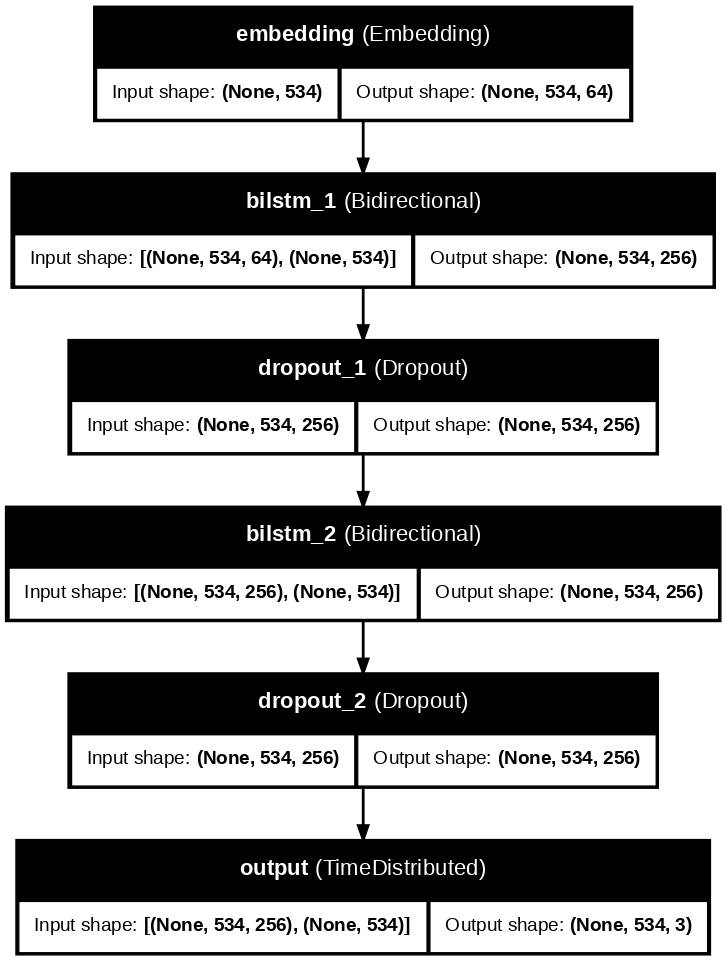

In [ ]:
# Visualize model architecture (optional - requires pydot)
try:
    keras.utils.plot_model(
        model,
        to_file='bilstm_model.png',
        show_shapes=True,
        show_layer_names=True,
        dpi=100
    )
    from IPython.display import Image
    display(Image('bilstm_model.png'))
except Exception as e:
    print(f"Could not generate model plot: {e}")
    print("Install graphviz and pydot for visualization.")

---
## 6. Train the Model

Training with:
- **EarlyStopping**: Stop when validation loss stops improving
- **ReduceLROnPlateau**: Reduce learning rate when stuck
- **ModelCheckpoint**: Save best model

In [ ]:
# Define callbacks

callbacks = [
    # Stop training when validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.001,
        verbose=1
    ),

    # Save the best model
    ModelCheckpoint(
        filepath='best_bilstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured.")

Callbacks configured.


In [ ]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 10  # Will likely stop early

print(f"Training Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Steps per epoch: {X_train.shape[0] // BATCH_SIZE}")

Training Configuration:
  Batch Size: 32
  Max Epochs: 10
  Training samples: 12817
  Steps per epoch: 400


In [ ]:
# Train the model

history = model.fit(
    X_train, y_train,
    sample_weight=sw_train,
    validation_data=(X_val, y_val, sw_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8084 - loss: 0.8790 - weighted_accuracy: 0.5911
Epoch 1: val_loss improved from inf to 0.78789, saving model to best_bilstm_model.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 130s 243ms/step - accuracy: 0.8084 - loss: 0.8788 - weighted_accuracy: 0.5911 - val_accuracy: 0.8404 - val_loss: 0.7879 - val_weighted_accuracy: 0.6490 - learning_rate: 0.0010
Epoch 2/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8449 - loss: 0.7799 - weighted_accuracy: 0.6552
Epoch 2: val_loss improved from 0.78789 to 0.76505, saving model to best_bilstm_model.keras
401/401 ━━━━━━━━━━━━━━━━━━━━ 91s 228ms/step - accuracy: 0.8449 - loss: 0.7798 - weighted_accuracy: 0.6552 - val_accuracy: 0.8455 - val_loss: 0.7651 - val_weighted_accuracy: 0.6601 - learning_rate: 0.0010
Epoch 3/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8530 - loss: 0.7450 - weighted_accuracy: 0.6731
Epoch 3: val_loss improved from 0.76505 to 0.68885, saving mode

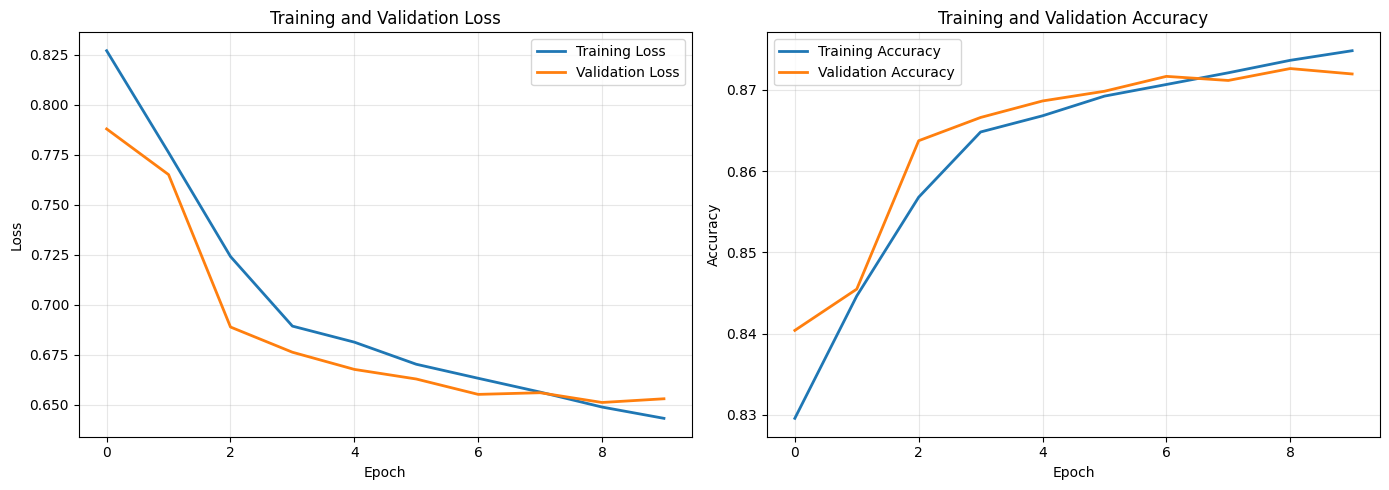

In [ ]:
# Plot training history

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Evaluate Performance

Evaluate on validation set with:
- Overall accuracy
- Per-class precision, recall, F1-score
- Confusion matrix

In [ ]:
# Make predictions on validation set

y_pred_probs = model.predict(X_val, batch_size=BATCH_SIZE, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=-1)  # Convert probabilities to class indices
y_true = np.argmax(y_val, axis=-1)         # Convert one-hot to class indices

print(f"Predictions shape: {y_pred.shape}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step
Predictions shape: (2262, 534)


In [ ]:
# Flatten predictions and labels, excluding padding positions

# Create mask for non-padding positions
mask = X_val != 0

# Flatten and filter
y_true_flat = y_true[mask]
y_pred_flat = y_pred[mask]

print(f"Total residues evaluated: {len(y_true_flat):,}")

Total residues evaluated: 549,217


In [ ]:
# Classification report

target_names = ['C (Coil)', 'H (Helix)', 'E (Sheet)']

print("Classification Report:")
print("=" * 60)
print(classification_report(y_true_flat, y_pred_flat, target_names=target_names, digits=4))

Classification Report:
              precision    recall  f1-score   support

    C (Coil)     0.6795    0.7344    0.7058    211653
   H (Helix)     0.7866    0.7665    0.7764    209506
   E (Sheet)     0.6820    0.6195    0.6492    128058

    accuracy                         0.7198    549217
   macro avg     0.7160    0.7068    0.7105    549217
weighted avg     0.7209    0.7198    0.7196    549217



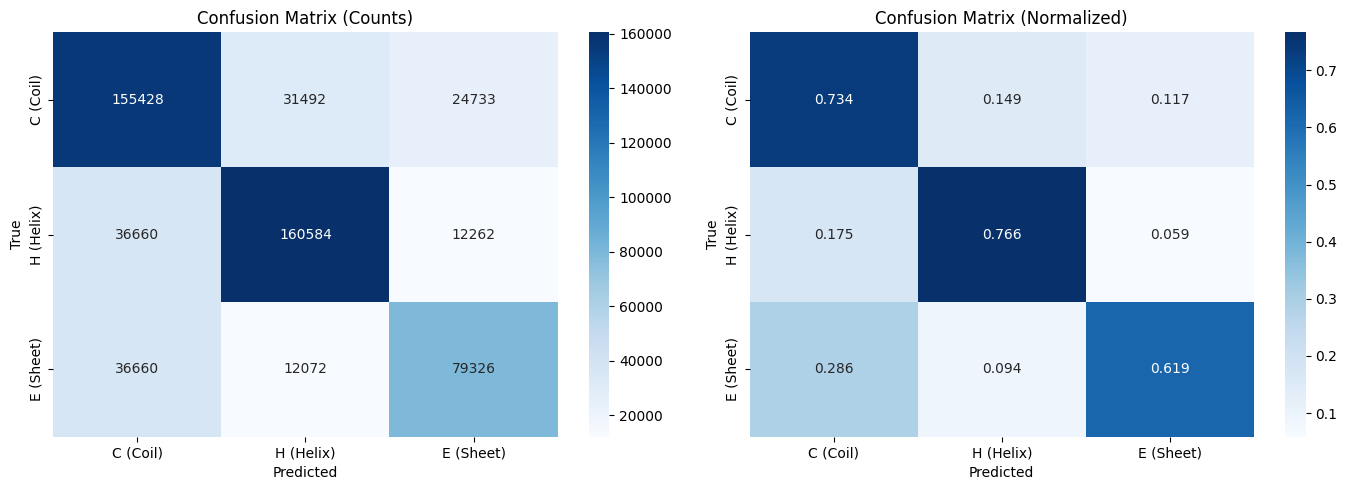

In [ ]:
# Confusion matrix

cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate Q3 accuracy (standard metric for 3-state SSP)

q3_accuracy = np.mean(y_true_flat == y_pred_flat) * 100
print(f"Q3 Accuracy: {q3_accuracy:.2f}%")

Q3 Accuracy: 71.98%


---
## 8. Predictions and Visualization

Visualize predictions on individual sequences.

In [ ]:
def predict_structure(model, sequence, aa_vocab, idx_to_ss, max_len):
    """
    Predict secondary structure for a single sequence.

    Args:
        model: Trained Keras model
        sequence: Amino acid sequence string
        aa_vocab: Amino acid to index mapping
        idx_to_ss: Index to secondary structure mapping
        max_len: Maximum sequence length

    Returns:
        Predicted secondary structure string
    """
    # Encode and pad
    encoded = encode_sequence(sequence, aa_vocab)
    padded = pad_sequences([encoded], maxlen=max_len, padding='post', value=0)

    # Predict
    pred_probs = model.predict(padded, verbose=0)
    pred_indices = np.argmax(pred_probs[0], axis=-1)

    # Convert back to structure symbols (only for original length)
    pred_structure = ''.join([idx_to_ss[idx] for idx in pred_indices[:len(sequence)]])

    return pred_structure

# Test on a validation sample
test_idx = 0
test_seq = df['seq'].iloc[test_idx]
true_sst3 = df['sst3'].iloc[test_idx]
pred_sst3 = predict_structure(model, test_seq, aa_to_idx, idx_to_sst3, MAX_SEQ_LEN)

print(f"Sequence ({len(test_seq)} residues):")
print(test_seq[:80] + "..." if len(test_seq) > 80 else test_seq)
print(f"\nTrue Structure:")
print(true_sst3[:80] + "..." if len(true_sst3) > 80 else true_sst3)
print(f"\nPredicted Structure:")
print(pred_sst3[:80] + "..." if len(pred_sst3) > 80 else pred_sst3)

Sequence (83 residues):
AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANCQFMQANVGEGDWKGCQLFPGKLINVNGWCASWTL...

True Structure:
CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHECCEEEEEEECCEEEECCCCCCEEECCCECCCCCE...

Predicted Structure:
CCCCCCCCCCCCCEEEEEECCCCCCCEEEEECCCCCCCCCCCCCCEEEEEEECCCCCEEEEEECCCCEEEECCEEEEEEE...


In [ ]:
def visualize_prediction(sequence, true_structure, pred_structure, start=0, length=100):
    """
    Visualize a portion of the prediction with color coding.
    """
    # Slice the sequences
    seq_slice = sequence[start:start+length]
    true_slice = true_structure[start:start+length]
    pred_slice = pred_structure[start:start+length]

    # Create comparison string
    match_str = ''.join(['✓' if t == p else '✗' for t, p in zip(true_slice, pred_slice)])

    # Calculate accuracy for this slice
    accuracy = sum(1 for t, p in zip(true_slice, pred_slice) if t == p) / len(true_slice) * 100

    print(f"Position {start} to {start + len(seq_slice)} (Accuracy: {accuracy:.1f}%)")
    print("=" * 60)
    print(f"Sequence:  {seq_slice}")
    print(f"True:      {true_slice}")
    print(f"Predicted: {pred_slice}")
    print(f"Match:     {match_str}")

# Visualize first 100 residues
visualize_prediction(test_seq, true_sst3, pred_sst3, start=0, length=100)

Position 0 to 83 (Accuracy: 54.2%)
Sequence:  AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANCQFMQANVGEGDWKGCQLFPGKLINVNGWCASWTLKAG
True:      CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHECCEEEEEEECCEEEECCCCCCEEECCCECCCCCECCC
Predicted: CCCCCCCCCCCCCEEEEEECCCCCCCEEEEECCCCCCCCCCCCCCEEEEEEECCCCCEEEEEECCCCEEEECCEEEEEEEECC
Match:     ✓✓✓✓✓✗✓✓✓✓✓✗✗✗✗✗✗✗✗✗✓✓✗✗✗✓✗✗✗✗✗✓✓✓✓✓✓✗✗✗✓✓✗✗✗✓✗✗✓✓✓✓✗✗✗✓✓✓✓✓✓✗✗✓✓✓✓✓✓✓✗✓✓✓✗✗✗✗✗✓✗✓✓


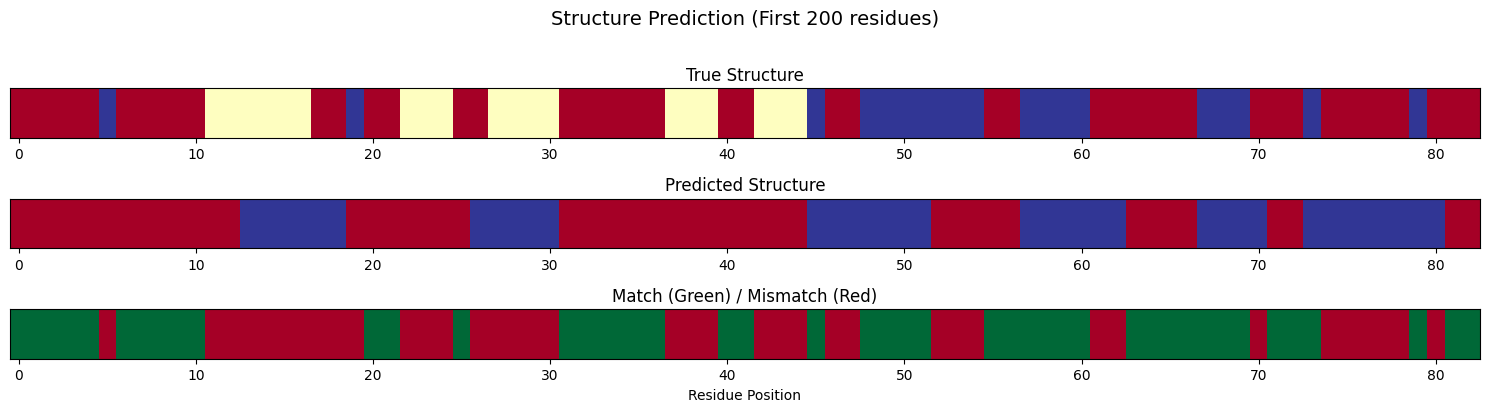

In [ ]:
def plot_structure_comparison(true_structure, pred_structure, title="Structure Comparison"):
    """
    Create a visual heatmap comparing true vs predicted structures.
    """
    # Convert to numeric
    ss_to_num = {'C': 0, 'H': 1, 'E': 2}
    true_num = [ss_to_num[s] for s in true_structure]
    pred_num = [ss_to_num[s] for s in pred_structure]

    fig, axes = plt.subplots(3, 1, figsize=(15, 4))

    # True structure
    axes[0].imshow([true_num], aspect='auto', cmap='RdYlBu', vmin=0, vmax=2)
    axes[0].set_yticks([])
    axes[0].set_title('True Structure')

    # Predicted structure
    axes[1].imshow([pred_num], aspect='auto', cmap='RdYlBu', vmin=0, vmax=2)
    axes[1].set_yticks([])
    axes[1].set_title('Predicted Structure')

    # Match/mismatch
    match = [1 if t == p else 0 for t, p in zip(true_structure, pred_structure)]
    axes[2].imshow([match], aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
    axes[2].set_yticks([])
    axes[2].set_xlabel('Residue Position')
    axes[2].set_title('Match (Green) / Mismatch (Red)')

    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot for first sequence
plot_structure_comparison(true_sst3[:200], pred_sst3[:200],
                          title=f"Structure Prediction (First 200 residues)")

---
## 9. Save and Load Model

Save the trained model and vocabularies for later use.

In [ ]:
import json

# Save the model
model.save('bilstm_ssp_model.keras')
print("Model saved to 'bilstm_ssp_model.keras'")

# Save vocabularies
vocab_data = {
    'aa_to_idx': aa_to_idx,
    'idx_to_aa': {str(k): v for k, v in idx_to_aa.items()},
    'sst3_to_idx': sst3_to_idx,
    'idx_to_sst3': {str(k): v for k, v in idx_to_sst3.items()},
    'max_seq_len': MAX_SEQ_LEN
}

with open('vocabularies.json', 'w') as f:
    json.dump(vocab_data, f, indent=2)
print("Vocabularies saved to 'vocabularies.json'")

Model saved to 'bilstm_ssp_model.keras'
Vocabularies saved to 'vocabularies.json'


In [ ]:
# Example: Load model and make prediction

# Load model
loaded_model = keras.models.load_model('bilstm_ssp_model.keras')

# Load vocabularies
with open('vocabularies.json', 'r') as f:
    vocab_data = json.load(f)

# Test prediction
test_sequence = "ACDEFGHIKLMNPQRSTVWY"  # All 20 standard amino acids
prediction = predict_structure(
    loaded_model,
    test_sequence,
    vocab_data['aa_to_idx'],
    {int(k): v for k, v in vocab_data['idx_to_sst3'].items()},
    vocab_data['max_seq_len']
)

print(f"Test sequence: {test_sequence}")
print(f"Predicted:     {prediction}")

Test sequence: ACDEFGHIKLMNPQRSTVWY
Predicted:     CCCCCCEEEEECCCCCEEEE


---
## Summary

### What We Built

1. **Amino Acid Vocabulary**: Maps 20 standard amino acids + special tokens to integers
2. **Data Pipeline**: Encodes sequences, pads to uniform length, handles masking
3. **BiLSTM Model**: 2-layer bidirectional LSTM for sequence-to-sequence prediction
4. **Evaluation**: Q3 accuracy, per-class metrics, confusion matrix

### Key Concepts

| Component | Purpose |
|-----------|--------|
| Vocabulary | Convert characters to integers |
| Embedding | Learn dense amino acid representations |
| BiLSTM | Capture bidirectional sequence context |
| TimeDistributed | Predict at each position independently |
| Masking | Ignore padding during training/evaluation |

### Next Steps

- Add attention mechanisms
- Try CNN+BiLSTM hybrid architectures
- Include PSSM or physicochemical features
- Experiment with transformer-based models (ProtBERT, ESM)